# Animal Classification

## 1. Initialization

In [1]:
# imports
import cv2, features, glob, helpers, os, pickle, sklearn, sys, time

import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd

from sklearn.decomposition import KernelPCA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.feature_selection import RFECV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# define constants
DATA_BASE_PATH = './'
OUTPUT_PATH='./'

DATA_TRAIN_PATH = os.path.join(DATA_BASE_PATH,'train')
DATA_TEST_PATH = os.path.join(DATA_BASE_PATH,'test')

FEATURE_BASE_PATH = os.path.join(OUTPUT_PATH,'features')
FEATURE_TRAIN_PATH = os.path.join(FEATURE_BASE_PATH,'features_train')
FEATURE_TEST_PATH = os.path.join(FEATURE_BASE_PATH,'features_test')

PREDICTION_PATH = os.path.join(OUTPUT_PATH,'predictions')

FILEPATTERN_DESCRIPTOR_TRAIN = os.path.join(FEATURE_TRAIN_PATH,'train_features_{}.pkl')
FILEPATTERN_DESCRIPTOR_TEST = os.path.join(FEATURE_TEST_PATH,'test_features_{}.pkl')

helpers.createPath(FEATURE_BASE_PATH)
helpers.createPath(FEATURE_TRAIN_PATH)
helpers.createPath(FEATURE_TEST_PATH)
helpers.createPath(PREDICTION_PATH)

# initialize variables
folder_paths = glob.glob(os.path.join(DATA_TRAIN_PATH, '*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
n_classes = label_strings.shape[0]
print(f'Number of classes = {n_classes}')
[print(f'{i}: {label_strings[i]}') for i in range(len(label_strings))]

train_paths = dict((label_string, helpers.getImgPaths(os.path.join(DATA_TRAIN_PATH,label_string))) for label_string in label_strings)
test_paths = helpers.getImgPaths(DATA_TEST_PATH)

Number of classes = 11
0: bobcat
1: chihuahua
2: collie
3: dalmatian
4: german_shepherd
5: leopard
6: lion
7: persian_cat
8: siamese_cat
9: tiger
10: wolf


## Preprocessing

In [2]:
# remove background
# mirror

## 2. Feature Extraction

In [2]:
def extract_features():
    # descriptors
    descriptor_dict={'daisy':features.extractDAISYCallback, # SIFT replacement, very fast, can be computed dense if necessary
                     'orb':features.extractORBCallback, # another fast SIFT replacement, oriented BRIEF w. FAST keypoints  
                     'freak':features.extractFREAKCallback, # biologically motivated descriptor
                     'lucid':features.extractLUCIDCallback,  
                     'vgg':features.extractVGGCallback, # Trained as proposed by VGG lab, don't confuse it with VGG-Net features
                     'boost_desc':features.extractBoostDescCallback} # Image descriptor learned with boosting
          
    if features.checkForSIFT():
        descriptor_dict['sift'] = features.extractSIFTCallback # One descriptor to rule them all, unfortunately patented
                 
    if features.checkForSURF():
        descriptor_dict['surf'] = features.extractSURFCallback
    
    # train features
    train_descriptor_dict = dict((key,value) for (key,value) in descriptor_dict.items() if not os.path.isfile(FILEPATTERN_DESCRIPTOR_TRAIN.format(key)))
    if len(train_descriptor_dict) > 0: 
        train_features = []
        train_labels = []
    
        train_features_by_descriptor = dict((key,[]) for (key,value) in train_descriptor_dict.items())
    
        for label_string in label_strings:
            print(f'extracting train features for class {label_string}')
            extracted_features = features.extractFeatures(train_paths[label_string], train_descriptor_dict, label_string)

            # append descriptors of corresponding label to correct descriptor list 
            for key in train_features_by_descriptor.keys():
                train_features_by_descriptor[key]+=extracted_features[key]
  
        for descriptor_key in train_features_by_descriptor.keys():
            with open(FILEPATTERN_DESCRIPTOR_TRAIN.format(descriptor_key),'wb') as pkl_file_train:
                pickle.dump(train_features_by_descriptor[descriptor_key], pkl_file_train, protocol=pickle.HIGHEST_PROTOCOL)

    # test features
    test_descriptor_dict=dict((key,value) for (key,value) in descriptor_dict.items() if not os.path.isfile(FILEPATTERN_DESCRIPTOR_TEST.format(key)))
    if len(test_descriptor_dict) > 0: 
        test_features = []
    
        print('extracting test features:')
        test_features_by_descriptor = features.extractFeatures(test_paths,test_descriptor_dict, None) 
    
        for descriptor_key in test_features_by_descriptor.keys():
            with open(FILEPATTERN_DESCRIPTOR_TEST.format(descriptor_key),'wb') as pkl_file_test:
                pickle.dump(test_features_by_descriptor[descriptor_key], pkl_file_test, protocol=pickle.HIGHEST_PROTOCOL)
                
def load_pkl_files(descriptors_desired, codebook_sizes):
    print('\nLoading pkl files ...')    
    # train features
    clustered_codebooks = []
    train_feature_dict = {}
    for index, descriptor in enumerate(descriptors_desired):
        print(descriptor)
        with open(FILEPATTERN_DESCRIPTOR_TRAIN.format(descriptor),'rb') as pkl_file_train:
            train_feature_dict[descriptor] = pickle.load(pkl_file_train)
        clustered_codebooks.append(helpers.createCodebook(train_feature_dict[descriptor], codebook_size=codebook_sizes[index]))

    n_encoded_images_train = len(train_feature_dict[descriptors_desired[0]])
        
    train_data=[]
    train_labels=[]
    for i in range(n_encoded_images_train):
        image_data = []
        for index, descriptor in enumerate(descriptors_desired):            
            bow_feature_vector = helpers.encodeImage(train_feature_dict[descriptor][i].data, clustered_codebooks[index])
            image_data = np.concatenate((image_data, bow_feature_vector), axis=0)

        train_data.append(image_data)
        train_labels.append(train_feature_dict[descriptors_desired[0]][i].label)

    print(f'Number of encoded train images: {n_encoded_images_train}')
    
    # test features
    test_feature_dict = {}
    for descriptor in descriptors_desired:
        with open(FILEPATTERN_DESCRIPTOR_TEST.format(descriptor),'rb') as pkl_file_test:
            test_feature_dict[descriptor] = pickle.load(pkl_file_test)

    n_encoded_images_test = len(test_feature_dict[descriptors_desired[0]])        
    
    test_data=[]
    for i in range(n_encoded_images_test):
        image_data = []
        for index, descriptor in enumerate(descriptors_desired):
            bow_feature_vector = helpers.encodeImage(test_feature_dict[descriptor][i].data, clustered_codebooks[index])
            image_data = np.concatenate((image_data, bow_feature_vector), axis=0)

        test_data.append(image_data)
        
    print(f'Number of encoded test images: {n_encoded_images_test}')
        
    return train_data, train_labels, test_data

def load_pkl_files_FV(descriptors_desired, mixture_sizes):
    print('\nLoading pkl files ...')    
    # train features
    clustered_mixtures = []
    train_feature_dict = {}
    for index, descriptor in enumerate(descriptors_desired):
        print(descriptor)
        with open(FILEPATTERN_DESCRIPTOR_TRAIN.format(descriptor),'rb') as pkl_file_train:
            train_feature_dict[descriptor] = pickle.load(pkl_file_train)
        clustered_mixtures.append(helpers.createGaussianMixture(train_feature_dict[descriptor], K_value=mixture_sizes[index]))

    n_encoded_images_train = len(train_feature_dict[descriptors_desired[0]])
        
    train_data=[]
    train_labels=[]
    for i in range(n_encoded_images_train):
        image_data = []
        for index, descriptor in enumerate(descriptors_desired):            
            bow_feature_vector = helpers.encodeImage_FV(train_feature_dict[descriptor][i].data, clustered_mixtures[index],gamma=0.1)
            image_data = np.concatenate((image_data, bow_feature_vector), axis=0)

        train_data.append(image_data)
        train_labels.append(train_feature_dict[descriptors_desired[0]][i].label)

    print(f'Number of encoded train images: {n_encoded_images_train}')
    
    # test features
    test_feature_dict = {}
    for descriptor in descriptors_desired:
        with open(FILEPATTERN_DESCRIPTOR_TEST.format(descriptor),'rb') as pkl_file_test:
            test_feature_dict[descriptor] = pickle.load(pkl_file_test)

    n_encoded_images_test = len(test_feature_dict[descriptors_desired[0]])        
    
    test_data=[]
    for i in range(n_encoded_images_test):
        image_data = []
        for index, descriptor in enumerate(descriptors_desired):
            bow_feature_vector = helpers.encodeImage_FV(test_feature_dict[descriptor][i].data, clustered_mixtures[index],gamma=0.1)
            image_data = np.concatenate((image_data, bow_feature_vector), axis=0)

        test_data.append(image_data)
        
    print(f'Number of encoded test images: {n_encoded_images_test}')
        
    return train_data, train_labels, test_data

def encode_labels(train_labels):
    print('\nEncoding labels ...')
    return LabelEncoder().fit_transform(train_labels)

def plot_histogram_train_labels(train_labels, n_classes):
    # plot histogram of train labels
    labelfreq, bins = np.histogram(train_labels, bins=range(n_classes + 1))
    plt.figure()
    plt.bar(range(n_classes), labelfreq)
    plt.show()
    print(f'Label frequencies = {labelfreq}')
    priors = labelfreq/np.linalg.norm(labelfreq)
    print(f'Priors = {priors}')
    return labelfreq, priors

def split_train_test_data(train_data, train_labels):
    print('\nSplitting train and test data ...')
    return train_test_split(train_data, train_labels, test_size=0.25, stratify=train_labels)

In [4]:
#descriptors_desired=['sift', 'surf', 'freak', 'vgg', 'boost_desc', 'daisy', 'lucid', 'orb']
descriptors_desired=['sift', 'freak', 'boost_desc', 'daisy', 'lucid']
#codebook_sizes = [400, 400, 400, 400, 400, 400, 400, 400]
mixture_sizes = [7,7,7,7,7,7]

#extract_features()
#train_data, train_labels, test_data = load_pkl_files_FV(descriptors_desired, mixture_sizes)
#train_labels = encode_labels(train_labels)
#labelfreq, priors = plot_histogram_train_labels(train_labels, n_classes)

x_train, x_test, r_train, r_test = split_train_test_data(train_data, train_labels)

In [40]:
def dump_data(train_data, train_labels, test_data):
    print('\nDumping data ...')
    train_data_out = open("train_data_FV.pickle", "wb")
    pickle.dump(train_data, train_data_out)
    train_labels_out = open("train_labels_FV.pickle", "wb")
    pickle.dump(train_labels, train_labels_out)
    test_data_out = open("test_data_FV.pickle", "wb")
    pickle.dump(test_data, test_data_out)
    
def load_data():
    print('\nLoading data ...')
    train_data_in = open("train_data_FV.pickle", "rb")
    train_data = pickle.load(train_data_in)
    train_labels_in = open("train_labels_FV.pickle", "rb")
    train_labels = pickle.load(train_labels_in)
    test_data_in = open("test_data_FV.pickle", "rb")
    test_data = pickle.load(test_data_in)
    return train_data, train_labels, test_data


Loading data ...


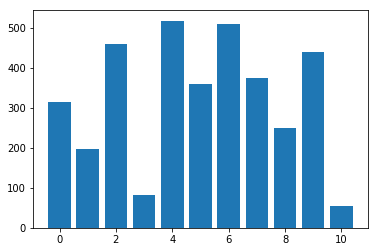

Label frequencies = [315 197 458  81 517 360 510 374 250 439  55]
Priors = [0.26532773 0.16593512 0.38577809 0.06822713 0.4354744  0.30323169
 0.42957822 0.31502403 0.21057756 0.3697742  0.04632706]

Splitting train and test data ...


In [41]:
#dump_data(train_data, train_labels, test_data)
train_data, train_labels, test_data = load_data()
plot_histogram_train_labels(train_labels, n_classes)
x_train, x_test, r_train, r_test = split_train_test_data(train_data, train_labels)

## Feature Selection

In [42]:
# pca
def do_pca(data, labels, pca_components=None, pca_threshold=0.9):
    print('\nDoing PCA ...')
    normalizer = Normalizer()
    pca = PCA(n_components=pca_components, whiten=True)
    pipe = Pipeline(steps=[('normalizer', normalizer),
                           ('pca', pca)])
    pipe.fit(data, labels)
    
    if pca_components == None:
        plt.plot(np.cumsum((pca.explained_variance_ratio_)))
        plt.axhline(y=pca_threshold, color='r', linestyle='-')
        plt.grid()
        plt.show()
        pca_components = int(np.argmax(np.cumsum(pca.explained_variance_ratio_) > pca_threshold))
        print(f'Number of PCA components = {pca_components}')
    return pca_components

def do_lda(data, labels, priors, lda_components=None):
    lda = LinearDiscriminantAnalysis()
    lda.fit(data, labels)
    
    if lda_components == None:
        plt.plot(np.cumsum((lda.explained_variance_ratio_)))
        plt.grid()
        plt.show()
        lda_components = len(lda.explained_variance_ratio_)
        print(f'Number of LDA components = {lda_components}')
    return lda_components


Doing PCA ...


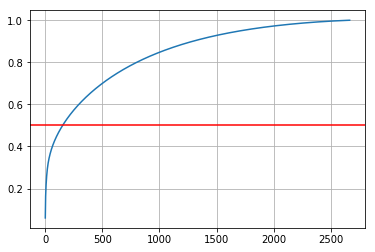

Number of PCA components = 152


In [43]:
pca_threshold = 0.5
pca_components = None
#lda_components = None

pca_components = do_pca(x_train, r_train, pca_threshold=pca_threshold)
#lda_components = do_lda(x_train, r_train, priors)

In [44]:
print(np.shape(x_train[0]))

(8491,)


## Model

In [45]:
def create_model(train_data, train_labels, test_data, pca_components, tuned_parameters):
    # grid search
    # preprocessing
    normalizer = Normalizer()
    #pca = PCA(n_components=pca_components, whiten=True)
    kernel_pca = KernelPCA(n_components=pca_components, n_jobs=-1)
    lda = LinearDiscriminantAnalysis(shrinkage=True)
    #selector = RFECV(model, step=0.4, cv=5)
    
    # create model and pipeline
    model = SVC(class_weight='balanced', probability = True)  
    pipe = Pipeline(steps=[('normalizer', normalizer),
                          ('kernel_pca', kernel_pca),
                           ('model', model)])
    
    # grid search with k-fold cross-validation
    grid_search = GridSearchCV(pipe, tuned_parameters, scoring='neg_log_loss', iid=False, cv=5, n_jobs=-1, refit=True, verbose=10)
    grid_search.fit(train_data, train_labels)
    
    print(f'Best parameters = {grid_search.best_params_}')
    print(f'Best score = {grid_search.best_score_}')
    
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")
        
    return grid_search.best_estimator_

In [46]:
kernel1 = 'rbf'
kernel2 = 'poly'
kernel3 = 'sigmoid'
tuned_parameters = [{'model__kernel': [kernel1],
                     'model__C': [10],
                     'model__degree': [2], 
                     'model__gamma': [0.1]
                    }
                   ]

pipe = create_model(x_train, r_train, x_test, pca_components, tuned_parameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.4s remaining:   38.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   26.7s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


Best parameters = {'model__C': 10, 'model__degree': 2, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best score = -1.2885882647932463
-1.289 (+/-0.069) for {'model__C': 10, 'model__degree': 2, 'model__gamma': 0.1, 'model__kernel': 'rbf'}


## Model Evaluation

In [47]:
import itertools

def do_predictions(pipe, test_data):
    return pipe.predict(test_data), pipe.predict_proba(test_data)
    
def print_scores(pipe, train_data, train_labels, test_data, test_labels, pred_proba):
    print(f"logloss = {log_loss(test_labels, pred_proba):.2f}")
    print(f"train   = {pipe.score(train_data, train_labels)*100:.1f} %")
    print(f"test    = {pipe.score(test_data, test_labels)*100:.1f} %")
    # uses StratifiedKFold
    scores = cross_val_score(pipe, x_train, r_train, cv=5)
    print(f"CVA     = {scores.mean()*100:.1f} %")
    print(f"CVS     = {scores.std()*100:.2f} %")

def plot_learning_curve(pipe, data, labels):
    plt.figure()
    # uses StratifiedKFold
    train_sizes, train_scores, test_scores = learning_curve(
        pipe, data, labels, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def show_confusion_matrix(labels, prediction):
    cm = confusion_matrix(labels, prediction)
    plt.imshow(cm)
    plt.colorbar()
    fmt = '.0f'
    thresh_plot = 10
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > thresh_plot:
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
def show_confusion_matrix_normalized(labels, prediction):
    cm = confusion_matrix(labels, prediction)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm)
    plt.colorbar()
    fmt = '.2f'
    thresh_plot = 0.1
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > thresh_plot:
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

logloss = 1.20
train   = 68.5 %
test    = 55.9 %
CVA     = 54.4 %
CVS     = 1.11 %


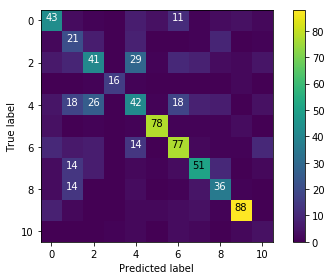

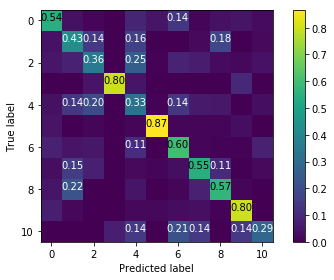

In [48]:
pred, pred_proba = do_predictions(pipe, x_test)
print_scores(pipe, x_train, r_train, x_test, r_test, pred_proba)
#plot_learning_curve(pipe, x_train, r_train)
show_confusion_matrix(r_test, pred)
show_confusion_matrix_normalized(r_test, pred)

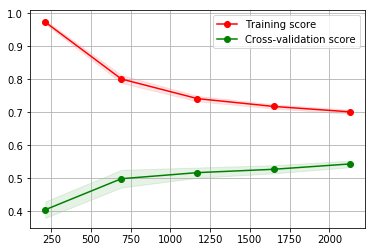

In [49]:
plot_learning_curve(pipe, x_train, r_train)

## Submission

In [14]:
def make_submission(pipe, train_data, train_labels, test_data, label_strings):
    print('\nMaking submission ...')
    pipe.fit(train_data, train_labels)
    predict_proba = pipe.predict_proba(test_data)

    pred_file_path = os.path.join(PREDICTION_PATH, helpers.generateUniqueFilename('pred', 'csv'))
    helpers.writePredictionsToCsv(predict_proba, pred_file_path, label_strings)

In [15]:
make_submission(pipe, train_data, train_labels, test_data, label_strings)


Making submission ...
